# DIFUSIÓN DEL CORONAVIRUS EN ESPAÑA:

## (5ª predicción: misma metodología que con mejor modelo de 4ª predicción)

## 0. INTRODUCCIÓN

Si se quieren ver directamente los resultados de los cálculos, y el pronóstico para los próximos 5 días, pinchar <a href='#a1'>**--> aquí**</a>.

Este es un pequeño ejercicio de extrapolación para la curva de contagios del coronavirus en España.

Como fuente de los datos, a falta de una mejor, se toman los volcados en la siguiente página:

https://www.rtve.es/noticias/20200316/mapa-del-coronavirus-espana/2004681.shtml

Que recoge los datos que vuelca el Ministerio de Sanidad español. La hora de los contagios en el día de dicho informe puede variar, por lo que la diferencia entre un día y otro puede ser mayor o menor de 24 horas, pero a priori se asumirá que la hora del informe de todos los días es la misma, por falta de referencias.

El modelo que emplearemos no será más que una sencilla aproximación por una exponencial, no se empleará el modelo SIR como primera aproximación, aunque este es sólo ligeramente más complejo.

Un modelo de contagio (no asumiendo que cada persona ya contagiada no podría volver a ser contagiada, o asumiendo que la fracción de la población contagiada aún es lo suficientemente baja como para despreciar dichos efectos, lo que es válido para el comienzo de la progresión de la pandemia) respondería a una ecuación diferencial del estilo de:

$y' = c y$

Cuya solución es de la forma:

$ y = K e^{c x}$

O, lo que es lo mismo:

$ y = H A^{b x}$

Donde, para que ambas expresiones sean la misma, tendremos que:

$b = \frac{K}{H \cdot ln(A)} c$

Por lo tanto, tomando logaritmos tendremos:

$ ln(y) = c x + K = b \cdot ln(A) x + H$

En donde tendremos ya una relación lineal.

Nuestro enfoque, por lo tanto, será el de calcular los coeficientes de esta recta.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)
datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

datos = datos.loc[:'2020-04-08', :]

contagios = pd.DataFrame(datos[['CONTAGIOS', 'DIFER_DIAS']])
muertos = pd.DataFrame(datos[['MUERTOS', 'DIFER_DIAS']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


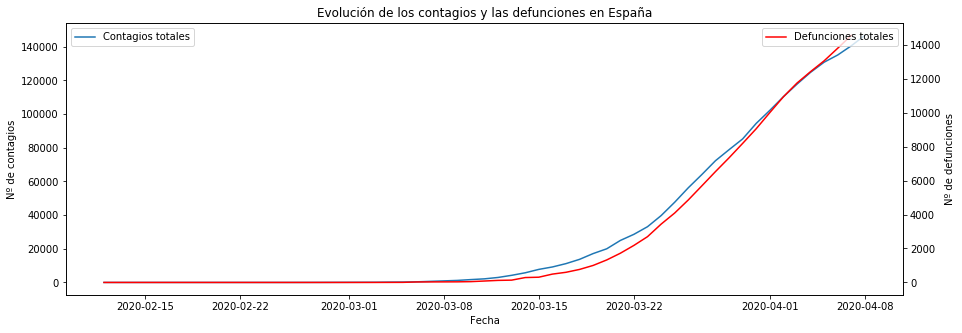

In [3]:
fig, ax1 = plt.subplots(figsize=(15,5))

plt.title('Evolución de los contagios y las defunciones en España')

ax1.plot(contagios.reset_index()['FECHA'], contagios['CONTAGIOS'], '-');
ax1.legend(['Contagios totales'])
ax1.set_ylabel("Nº de contagios")
ax1.set_xlabel("Fecha")

ax2 = ax1.twinx()

ax2.plot(muertos.reset_index()['FECHA'], muertos['MUERTOS'].shift(-1), '-', color='r')
ax2.legend(['Defunciones totales'], loc = 1)
ax2.set_ylabel("Nº de defunciones");

## 1. CONTAGIOS

**Paso 1:**

**Comprobaciones sobre la serie:**

Examinamos primero los datos de los contagios:

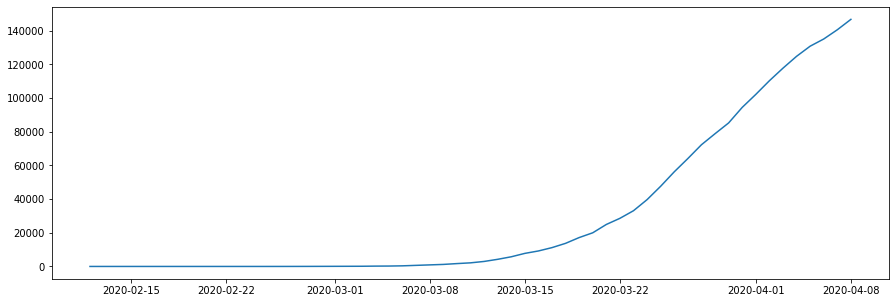

In [4]:
plt.figure(figsize=(15,5))
plt.plot(contagios.index, contagios['CONTAGIOS'], '-');

Como podemos ver, tenemos una curva monótona creciente que, aparentemente, parece seguir la forma de una exponencial.

Examinamos ahora la serie en diferencias. Como se sabe, si la serie original sigue una exponencial, la serie en diferencias debería seguir también una exponencial:

In [5]:
contagios['DIFER'] = contagios['CONTAGIOS'].diff(1).fillna(2)/contagios['DIFER_DIAS']

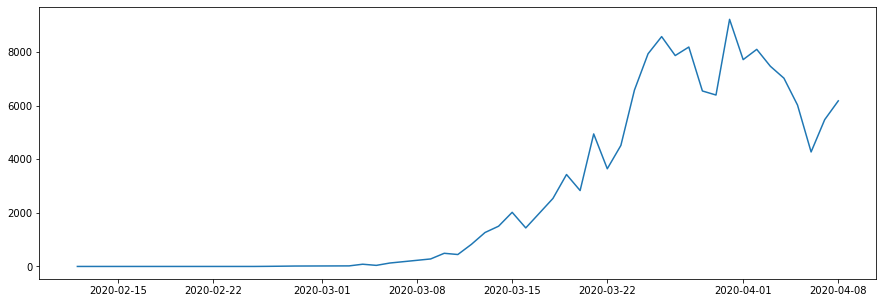

In [6]:
plt.figure(figsize=(15,5))
plt.plot(contagios['DIFER'], '-');

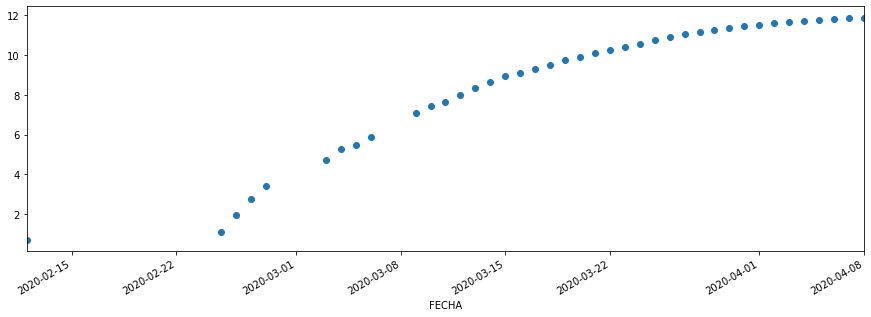

In [7]:
contagios['LN_CONTAGIOS'] = contagios['CONTAGIOS'].apply(lambda x: np.log(x) if x>0 else 0)
# Añadimos +1 por criterios de estabilidad con el logaritmo:
contagios['LN_DIFER'] = contagios['DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)

contagios['LN_CONTAGIOS'].plot(figsize=(15,5), style = 'o')

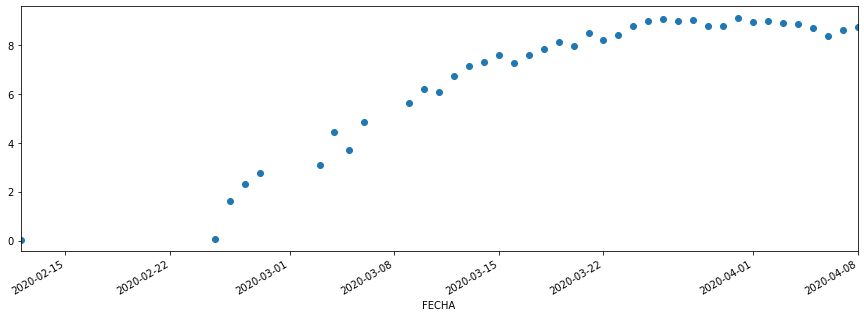

In [8]:
contagios['LN_DIFER'].plot(figsize=(15,5), style = 'o')

Como podemos ver, ante nosotros no tenemos una recta, sino más bien un comportamiento más bien parabólico, característico de funciones como una raíz cuadrada.

Esto son buenas noticias, porque nos indica que el virus no se está propagando siguiendo una exponencial, sino más bien una exponencial algo amortiguada.

También podemos observar un comportamiento errático en la serie de las diferencias de los logaritmos de los contagios diarios.

Vamos a examinar la serie de sus diferencias. Si el proceso fuese exponencial, estas deberían ser constantes:

In [9]:
contagios['LN_CONTAGIOS_DIFER'] = contagios['LN_CONTAGIOS'].diff(1).fillna(0)/contagios['DIFER_DIAS']

In [10]:
def rolling_average(series: pd.Series, periods: int, centered: bool):
    
    rolling = series.rolling(window = 3, center = True).mean()
    rolling[rolling.isna()] = series
    rolling = rolling * (series.sum()/rolling.sum())
    
    return rolling

In [11]:
contagios['MVA3_DIFER'] = rolling_average(contagios['DIFER'], 3, True)
contagios['LN_MVA3_DIFER'] = contagios['MVA3_DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)

### MODELOS:

In [12]:
def cols_para_calculos(df: 'DataFrame', dates_in_index = True):
    
    if dates_in_index:
        day_range = (df.index - df.index[0]).days
        df.loc[:,'FECHA'] = day_range
    else:
        df['FECHA'] =(df.index - df.index[0])
    
    return df

In [13]:
def ajuste_min_cuadrados(serie_x: 'Series', serie_y: 'Series', col: 'string'):
    
    
    # Añadimos en el polyfit unos pesos exponenciales sobre el factor de corrección, 
    # para que el modelo ajuste el peso de los errores según los que tendrían con la distribución original 
    # del valor en y, y no la propia recta:
    
    x_range = serie_x
    coefs = np.polyfit(np.array(x_range), np.array(serie_y) , deg = 2, w=(np.exp(serie_y)))

    arr_pred =  x_range**2 * coefs[0] + x_range * coefs[1] + coefs[2]

    df_pred = pd.DataFrame(arr_pred)
    df_pred.rename({'FECHA':'PRED'}, axis=1, inplace = True)
    df_pred['SERIE'] = serie_y
    
    
    df_pred.plot(figsize=(18,5))
    print(df_pred.corr())
    
    df_pred[col] = np.round(np.exp(df_pred['PRED']).fillna(1))

    return df_pred, coefs

In [14]:
def prediccion(day_num_of_reference, date_of_reference, coeficientes, entre=(1,6)):    

    x_range_ext = np.array(range(day_num_of_reference + entre[0], day_num_of_reference + entre[1]))
    index = [date_of_reference + datetime.timedelta(int(x)) for x in x_range_ext]
    arr_pred = x_range_ext**2 * coeficientes[0] + x_range_ext * coeficientes[1] + coeficientes[2]

    arr_pred = np.round(np.exp(arr_pred))
    arr_pred = pd.DataFrame(arr_pred, columns = ['PRED'], index = index)
    return arr_pred

**EMPLEANDO LA SERIE DE CONTAGIOS DIARIOS:**

Vamos por lo tanto a aplicar el mismo método a la serie de contagios diarios, y luego hacer su suma agregada para obtener los valores totales:

In [15]:
contagios.drop(contagios.index[[0]], inplace = True)
df_contagios_pred = contagios[['CONTAGIOS', 'DIFER_DIAS', 'LN_CONTAGIOS', 'DIFER', 'LN_DIFER', 'MVA3_DIFER', 'LN_MVA3_DIFER']].copy()
df_contagios_pred = cols_para_calculos(df_contagios_pred)

day_num_of_reference = df_contagios_pred['FECHA'][-1]
date_of_reference = df_contagios_pred.index[0]

          PRED    SERIE
PRED   1.00000  0.99741
SERIE  0.99741  1.00000


,PRED
2020-04-09,4364.0
2020-04-10,3806.0
2020-04-11,3274.0
2020-04-12,2779.0
2020-04-13,2327.0


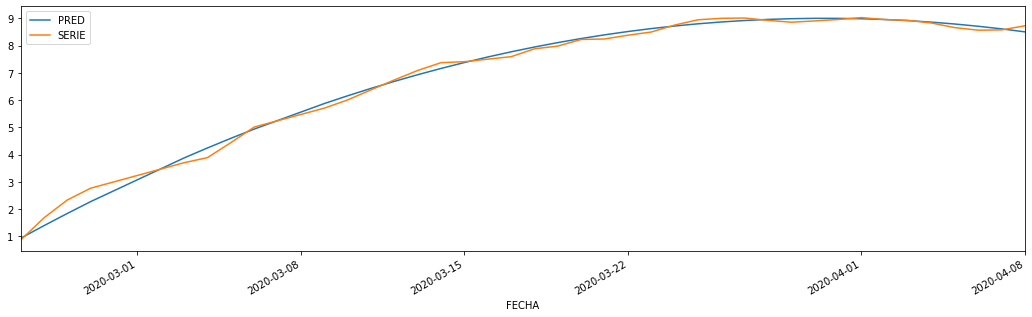

In [16]:
new_contagios_prediction_2, coefs = ajuste_min_cuadrados(df_contagios_pred['FECHA'], 
                                                       df_contagios_pred['LN_MVA3_DIFER'], 
                                                       'PRED_CONT_DIARIOS')

df_contagios_pred['PRED_CONT_DIARIOS'] = new_contagios_prediction_2['PRED_CONT_DIARIOS']
df_contagios_pred['ERROR_DIFER_ABS'] = abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])
df_contagios_pred['ERROR_DIFER_REL'] = (abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])/df_contagios_pred['DIFER']).fillna(0)

arr_contagios_diarios_pred_2 = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_contagios_diarios_pred_2

In [17]:
arr_contagios_pred_2 = arr_contagios_diarios_pred_2.cumsum() + df_contagios_pred.loc[df_contagios_pred.index[-1],'CONTAGIOS']
arr_contagios_pred_2

,PRED
2020-04-09,151054.0
2020-04-10,154860.0
2020-04-11,158134.0
2020-04-12,160913.0
2020-04-13,163240.0


Este modelo arroja resultados en la línea del anterior, pero con un comportamiento menos agresivo y un valor de pico mucho menos elevado.

Como podemos ver, la diferencia porcentual entre ambos no es muy elevada, pero sí es acumulativa, y acaba siendo para la última de las fechas a predecir, del orden de un 5%:

## 2. MUERTOS

Pasamos ahora a comprobar los de los muertos. Representamos a continuación la curva del total acumulado de muertos en España:

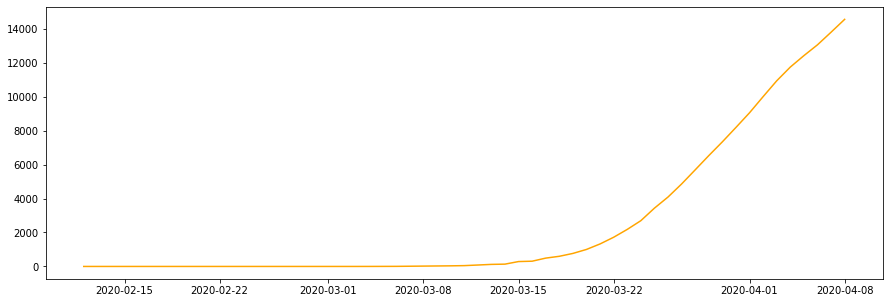

In [18]:
plt.figure(figsize=(15,5))
plt.plot(muertos['MUERTOS'], '-', color='orange');

Eliminamos, como en el caso de los contagios, el valor correspondiente al 12 de febrero:

In [19]:
muertos.drop(muertos.index[[0]], inplace = True)

A continuación, la evolución del ratio de muertos a infectados:

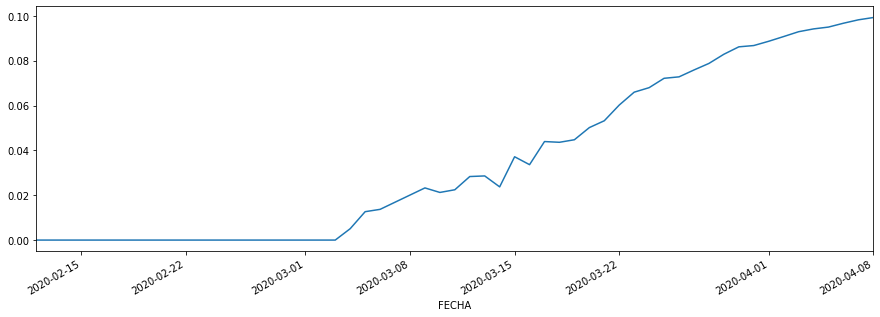

In [20]:
datos['ratio'] = datos['MUERTOS']/datos['CONTAGIOS']
datos['ratio'].plot(figsize=(15,5));

Y el ratio de muertes provocadas por la enfermedad cada día:

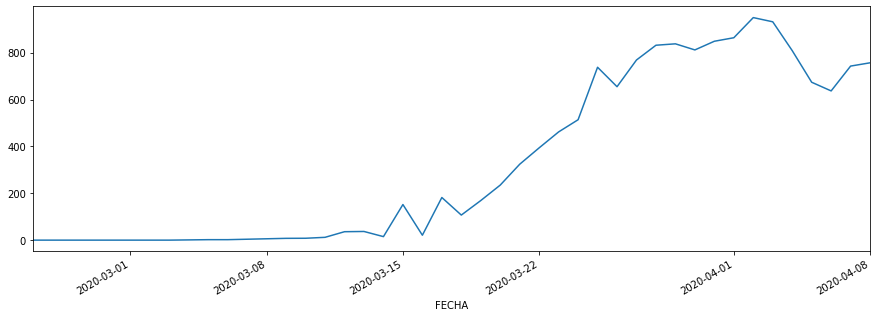

In [21]:
muertos['MUERTOS_DIARIOS'] = muertos['MUERTOS'].diff().fillna(0)/muertos['DIFER_DIAS']
muertos['MUERTOS_DIARIOS'].plot(figsize = (15,5))

Y, como en el caso de los contagios, la forma que presenta el logaritmo de las muertes acumuladas por la enfermedad, día tras día:

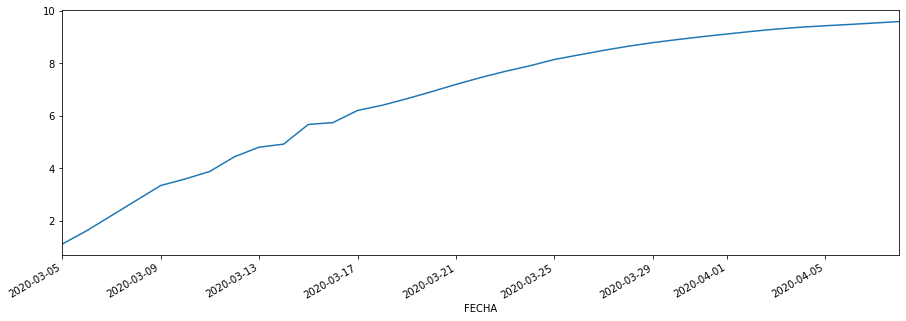

In [22]:
muertos['LN_MUERTOS'] = muertos['MUERTOS'].apply(lambda x: 0 if x == 0 else np.log(x))
muertos['LN_MUERTOS_DIARIOS'] = muertos['MUERTOS_DIARIOS'].apply(lambda x: 0 if x == 0 else np.log(x))
muertos[muertos['LN_MUERTOS'] != 0]['LN_MUERTOS'].plot(figsize=(15,5));

In [23]:
muertos['MVA3_DIFER'] = rolling_average(muertos['MUERTOS_DIARIOS'], 3, True)

muertos['LN_MVA3_DIFER'] = muertos['MVA3_DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)

## MODELOS:

**EMPLEANDO LA SERIE DE DEFUNCIONES DIARIAS:**

Al igual que hicimos con la serie de contagios, vamos a realizar el mismo ajuste sobre la serie de los muertos diarios:

           PRED     SERIE
PRED   1.000000  0.998645
SERIE  0.998645  1.000000


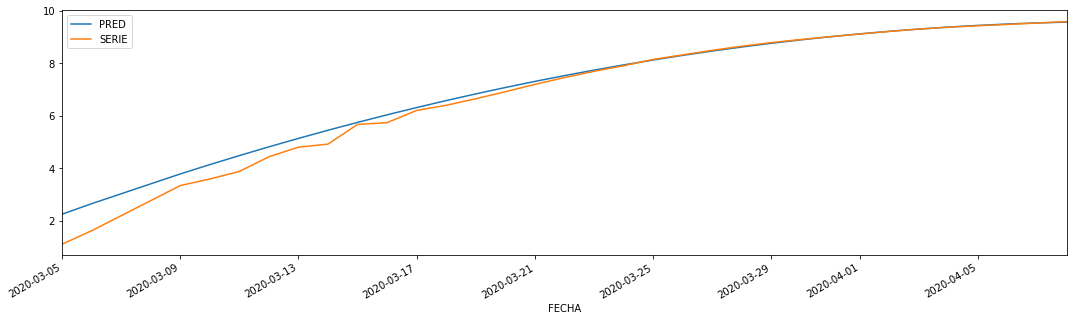

In [24]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

df_muertos_pred = muertos.loc[muertos['LN_MUERTOS'] != 0, ['MUERTOS', 'DIFER_DIAS', 'LN_MUERTOS', 'MVA3_DIFER', 'LN_MVA3_DIFER']].copy()
df_muertos_pred = cols_para_calculos(df_muertos_pred)
other_prediction, coefs = ajuste_min_cuadrados(df_muertos_pred['FECHA'], df_muertos_pred['LN_MUERTOS'], 'PRED_MUERTES')

           PRED     SERIE
PRED   1.000000  0.994626
SERIE  0.994626  1.000000


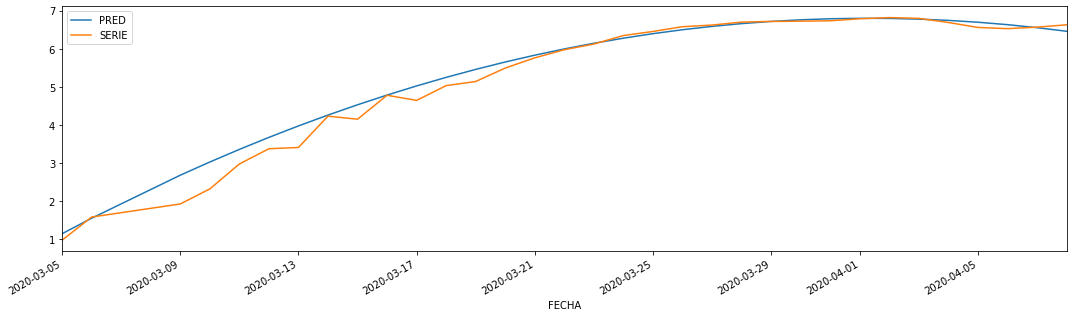

In [25]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

df_muertos_diarios_pred = muertos.loc[muertos['LN_MUERTOS_DIARIOS'] != 0, 
                                      ['MUERTOS_DIARIOS', 'MVA3_DIFER', 'DIFER_DIAS', 'LN_MVA3_DIFER']].copy()

df_muertos_diarios_pred = cols_para_calculos(df_muertos_diarios_pred)

new_pred_muertos_diarios, coefs = ajuste_min_cuadrados(df_muertos_diarios_pred['FECHA'], 
                                                       df_muertos_diarios_pred['LN_MVA3_DIFER'], 
                                                       'PRED_MUERTES_DIARIAS')

In [26]:
day_num_of_reference = df_muertos_pred['FECHA'][-1]
date_of_reference = muertos[muertos['LN_MUERTOS'] != 0].index[0]

arr_muertos_diarios_pred_2 = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_muertos_diarios_pred_2

,PRED
2020-04-09,574.0
2020-04-10,507.0
2020-04-11,441.0
2020-04-12,378.0
2020-04-13,319.0


In [27]:
arr_muertos_pred_2 = arr_muertos_diarios_pred_2.cumsum() + muertos.iloc[-1,0]
arr_muertos_pred_2

,PRED
2020-04-09,15129.0
2020-04-10,15636.0
2020-04-11,16077.0
2020-04-12,16455.0
2020-04-13,16774.0


## 3. PREDICCIONES<a id='a1'></a>

Presentamos finalmente las predicciones, de seguir presentando la expansión del virus el comportamiento actual:

**CONTAGIOS (contagiados diarios)**

In [28]:
print('ESTIMACIÓN CONTAGIOS DIARIOS: \n\n', arr_contagios_diarios_pred_2, '\n\n')

ESTIMACIÓN CONTAGIOS DIARIOS: 

               PRED
2020-04-09  4364.0
2020-04-10  3806.0
2020-04-11  3274.0
2020-04-12  2779.0
2020-04-13  2327.0 




In [29]:
x_range_ext = np.array(range(1,6))
index = [contagios.index[-1] + datetime.timedelta(int(x)) for x in x_range_ext]

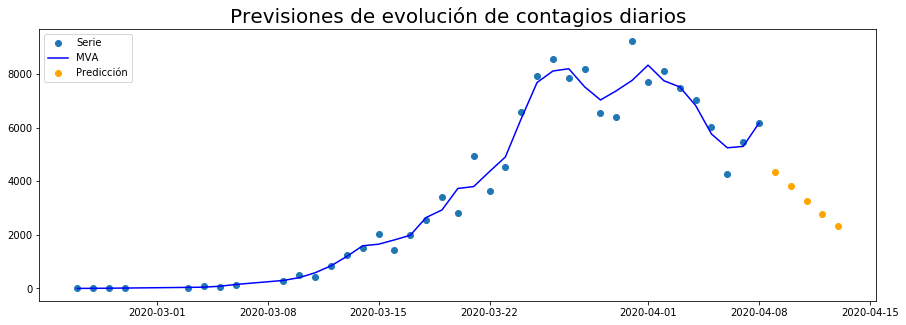

In [30]:
plt.figure(figsize = (15,5))

plt.title('Previsiones de evolución de contagios diarios', size = 20)

plt.plot(contagios.index, contagios['DIFER'], 'o', label = 'Serie')

plt.plot(contagios.index, contagios['MVA3_DIFER'], color = 'blue', label = 'MVA')

plt.plot(index, arr_contagios_diarios_pred_2, 'o', color = 'orange',  label = 'Predicción')
plt.legend(loc = 2);

**CONTAGIOS (contagiados totales)**

In [31]:
print('ESTIMACIÓN CONTAGIADOS TOTALES: \n\n', arr_contagios_pred_2, '\n\n')

ESTIMACIÓN CONTAGIADOS TOTALES: 

                 PRED
2020-04-09  151054.0
2020-04-10  154860.0
2020-04-11  158134.0
2020-04-12  160913.0
2020-04-13  163240.0 




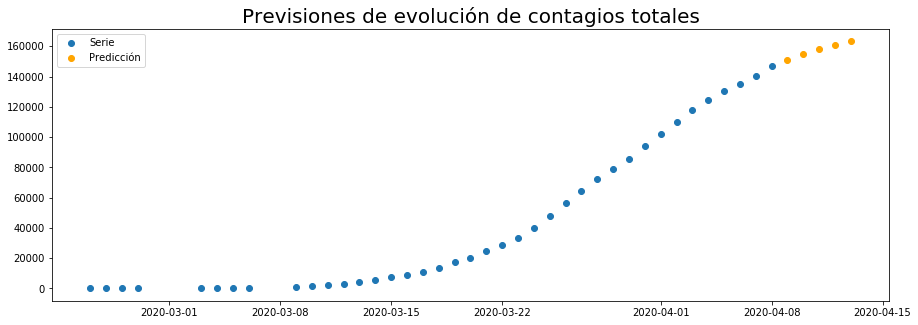

In [32]:
plt.figure(figsize = (15,5))

plt.title('Previsiones de evolución de contagios totales', size = 20)

plt.plot(contagios.index, contagios['CONTAGIOS'], 'o', label = 'Serie')

plt.plot(index, arr_contagios_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);

**MUERTOS (muertos diarios)**

In [33]:
print('ESTIMACIÓN DEFUNCIONES DIARIAS: \n\n', arr_muertos_diarios_pred_2, '\n\n')

ESTIMACIÓN DEFUNCIONES DIARIAS: 

              PRED
2020-04-09  574.0
2020-04-10  507.0
2020-04-11  441.0
2020-04-12  378.0
2020-04-13  319.0 




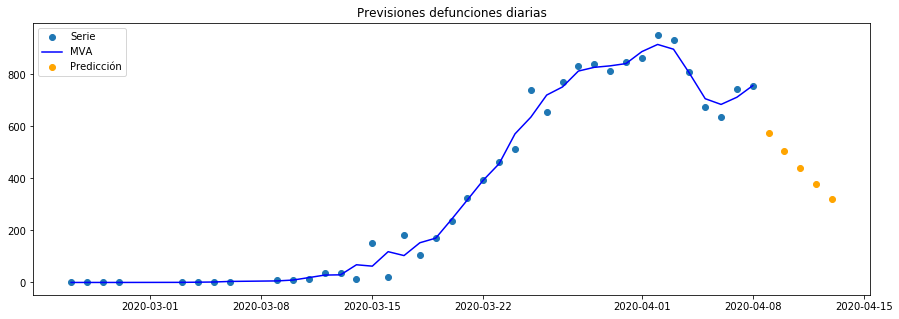

In [34]:
plt.figure(figsize = (15,5))

plt.title('Previsiones defunciones diarias')

plt.plot(muertos.index, muertos.loc[muertos.index, 'MUERTOS_DIARIOS'], 'o', label = 'Serie')

plt.plot(contagios.index, muertos['MVA3_DIFER'], color = 'blue', label = 'MVA')

plt.plot(index, arr_muertos_diarios_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);

**MUERTOS (total defunciones)**

In [35]:
print('ESTIMACIÓN TOTAL DEFUNCIONES: \n\n', arr_muertos_pred_2, '\n\n')

ESTIMACIÓN TOTAL DEFUNCIONES: 

                PRED
2020-04-09  15129.0
2020-04-10  15636.0
2020-04-11  16077.0
2020-04-12  16455.0
2020-04-13  16774.0 




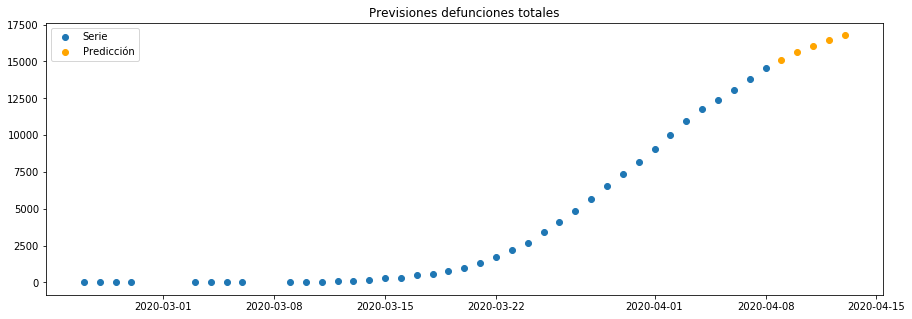

In [36]:
plt.figure(figsize = (15,5))

plt.title('Previsiones defunciones totales')

plt.plot(muertos.index, muertos.loc[muertos.index, 'MUERTOS'], 'o', label = 'Serie')

plt.plot(index, arr_muertos_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);